# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [3]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

In [5]:
conv_layer1 = nn.Conv2d(3, 6, kernel_size=5, stride=1)
x2 = conv_layer1(x)
max_pool1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=0)

x2 = max_pool1(x2)
print(x2.size())

torch.Size([64, 6, 26, 26])


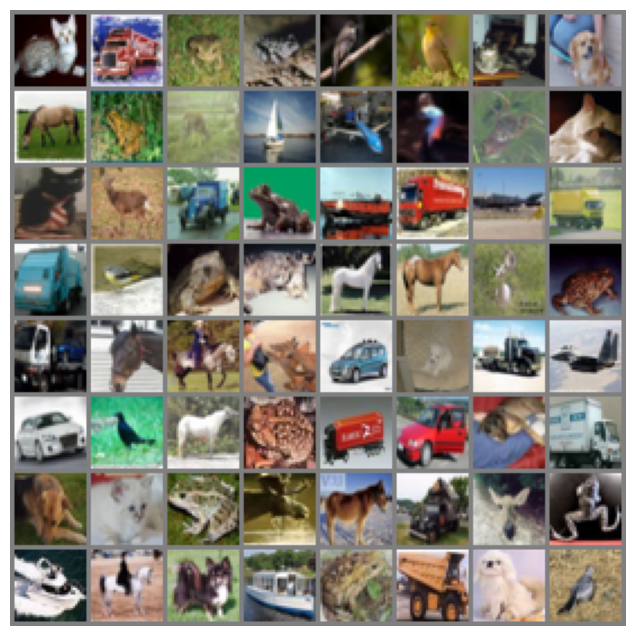

In [6]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [252]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, CFG):
        super().__init__()

        # layer agnostic functions
        self.dropout = nn.Dropout(p=CFG.dropout_rate)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)

        # layer 1
        self.layer1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=1),
                                    self.batchnorm1,
                                    self.activation,
                                    nn.Conv2d(16, 32, kernel_size=3, stride=1),
                                    self.activation,
                                    self.maxpool)
        # layer 2
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1),
                                self.activation,
                                nn.Conv2d(64, 128, kernel_size=3, stride=1),
                                self.activation,
                                self.maxpool)
        
        self.layer3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=2, stride=1),
                                self.activation,
                                self.maxpool)
        
        
        self.fc1 = nn.Linear(256*2*2, CFG.hidden_dim)
        self.fc2 = nn.Linear(CFG.hidden_dim, 128)
        self.fc3 = nn.Linear(128, CFG.n_classes)

    def forward(self, x):
        # Your code here!
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #print("x: ", x.shape)
        x = self.dropout(self.activation(self.fc1(x.view(x.size(0), -1))))
        x = self.dropout(self.activation(self.fc2(x)))
        logits = self.fc3(x)
        return logits

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [253]:
loss_fn = nn.CrossEntropyLoss()  # Your code here!
optimizer = None  # Your code here! (See further below!)

## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [272]:
# Define config with hyperparameters
class CFG:
    def __init__(self):
        # training params
        self.batch_size = 64
        self.n_epochs = 25
        self.validation_freq = 500
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.early_stopping_patience = 4 # if best validation acc has not improved after <val> validations stop training

        # model params
        self.n_classes = 10
        self.hidden_dim = 512
        self.dropout_rate=0.2
        

        # optimizer params
        self.lr = 0.01
        self.weight_decay=0.001
        self.betas = (0.9, 0.99) # for Adam
        self.momentum = 0.9 # for SGD

model = Model(CFG())

In [274]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[ 0.05835731  0.00361293 -0.01890082 -0.03891077 -0.03349273 -0.04306072
  -0.05143303 -0.06041512 -0.01016545  0.03626234]
 [ 0.05314979  0.00734208 -0.00844123 -0.03002089 -0.01709555 -0.0422791
  -0.04825891 -0.05720662 -0.03002526  0.04917149]]
Output probabilities:
[[0.10762595 0.1018924  0.09962405 0.09765039 0.0981809  0.09724598
  0.09643521 0.0955729  0.10049812 0.10527403]
 [0.1066993  0.1019219  0.10032586 0.09818406 0.09946135 0.09698784
  0.09640961 0.09555081 0.09818363 0.10627566]]


In [275]:
def trainer(CFG, model, criterion):
    model.to(CFG.device)
    print(f'Model is training on {CFG.device}')

    train_accuracies = []
    valid_accuracies = []
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=CFG.momentum)
    #optimizer = optim.Adam(model.parameters(), lr=CFG.lr, betas=CFG.betas, weight_decay=CFG.weight_decay)
    step=0
    best_val_acc = (np.inf, -1) # value, index of best validation accuracy
    for epoch in range(CFG.n_epochs):
        print(f'Epoch {epoch}')
        train_accuracies_batches = []
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(CFG.device), targets.to(CFG.device)
            
            # Forward pass, compute gradients, perform one training step.
            # Your code here!
            output = model.forward(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Increment step counter
            step += 1
            
            # Compute accuracy.
            predictions = output.max(1)[1]
            train_accuracies_batches.append(accuracy(targets, predictions))
            
            if step % CFG.validation_freq == 0:
                
                # Append average training accuracy to list.
                train_accuracies.append(np.mean(train_accuracies_batches))
                
                train_accuracies_batches = []
            
                # Compute accuracies on validation set.
                valid_accuracies_batches = []
                with torch.no_grad():
                    model.eval()
                    for inputs, targets in test_loader:
                        inputs, targets = inputs.to(CFG.device), targets.to(CFG.device)
                        output = model(inputs)
                        loss = loss_fn(output, targets)

                        predictions = output.max(1)[1]

                        # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                        valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                    model.train()
                    
                # Append average validation accuracy to list.
                valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
        
                print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
                print(f"             test accuracy: {valid_accuracies[-1]}")
                best_val_acc = (max(valid_accuracies), np.argmax(valid_accuracies))
            
                # early stopping
                if len(valid_accuracies) - best_val_acc[1] > CFG.early_stopping_patience:
                    break

    print("Finished training.")
    return train_accuracies, valid_accuracies

In [276]:
cfg = CFG()
model = Model(cfg)
trainer(cfg, model=model, criterion=loss_fn)

Model is training on cuda
Epoch 0
Step 500     training accuracy: 0.106625
             test accuracy: 0.1473
Epoch 1
Step 1000    training accuracy: 0.2589592889908257
             test accuracy: 0.304
Step 1500    training accuracy: 0.347375
             test accuracy: 0.4106
Epoch 2
Step 2000    training accuracy: 0.44323394495412843
             test accuracy: 0.4893
Epoch 3
Step 2500    training accuracy: 0.5304383116883117
             test accuracy: 0.5345
Step 3000    training accuracy: 0.56059375
             test accuracy: 0.6005
Epoch 4
Step 3500    training accuracy: 0.6150873655913979
             test accuracy: 0.6149
Epoch 5
Step 4000    training accuracy: 0.6541666666666667
             test accuracy: 0.6609
Step 4500    training accuracy: 0.67615625
             test accuracy: 0.6797
Epoch 6
Step 5000    training accuracy: 0.7165178571428571
             test accuracy: 0.7025
Epoch 7
Step 5500    training accuracy: 0.7349759615384616
             test accuracy: 0.7068


([0.106625,
  0.2589592889908257,
  0.347375,
  0.44323394495412843,
  0.5304383116883117,
  0.56059375,
  0.6150873655913979,
  0.6541666666666667,
  0.67615625,
  0.7165178571428571,
  0.7349759615384616,
  0.75421875,
  0.7871413934426229,
  0.775875,
  0.8100311147186147,
  0.8421875,
  0.82684375,
  0.855998743718593,
  0.8829471982758621,
  0.8605625,
  0.8875374251497006,
  0.9071514423076923,
  0.8961875,
  0.9086805555555556,
  0.90871875,
  0.9165625,
  0.918875,
  0.9258125,
  0.9305625,
  0.936875,
  0.93634375,
  0.9375,
  0.943375],
 [0.1473,
  0.304,
  0.4106,
  0.4893,
  0.5345,
  0.6005,
  0.6149,
  0.6609,
  0.6797,
  0.7025,
  0.7068,
  0.727,
  0.7261,
  0.7386,
  0.7491,
  0.757,
  0.7641,
  0.7543,
  0.7542,
  0.7681,
  0.7574,
  0.765,
  0.7602,
  0.7668,
  0.7681,
  0.762,
  0.7634,
  0.7573,
  0.7657,
  0.7666,
  0.7627,
  0.7612,
  0.7588])

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

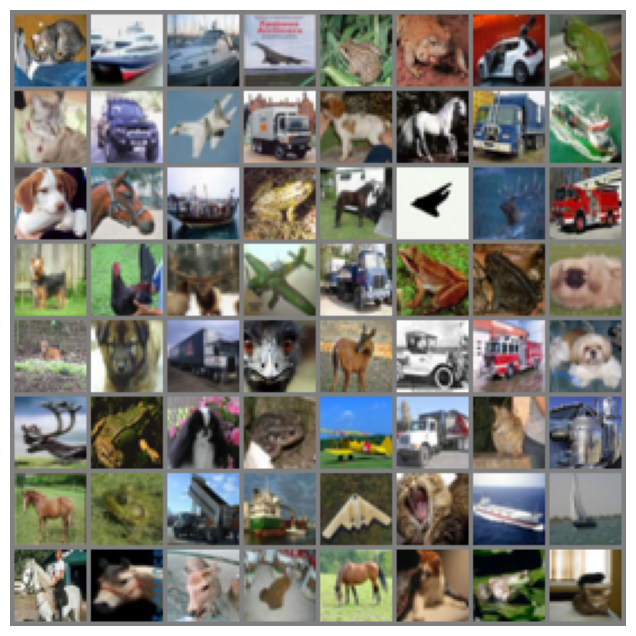

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          deer     
    frog          frog     
 automobile    automobile  
    frog          bird     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog          deer     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           cat     
    horse          cat     
    ship          ship     
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer          deer     
    truck         truck    
     dog          deer     
    bird           cat     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          bird     
    frog          frog     
     dog           dog     
    deer          deer     
     dog           c

In [279]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(cfg.device), targets.to(cfg.device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [281]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(cfg.device), targets.to(cfg.device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [282]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.759


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


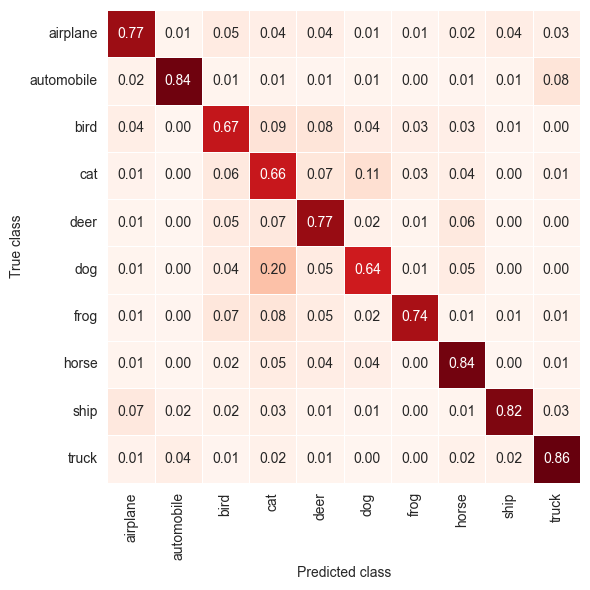

In [283]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

c:\Users\micha\OneDrive\Skrivebord\02456-deep-learning-with-PyTorch\DLenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\micha\OneDrive\Skrivebord\02456-deep-learning-with-PyTorch\DLenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\micha\OneDrive\Skrivebord\02456-deep-learning-with-PyTorch\DLenv\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\micha\OneDrive\Skrivebord\02456-deep-learning-with-PyTorch\DLenv\lib\site-packages\sea

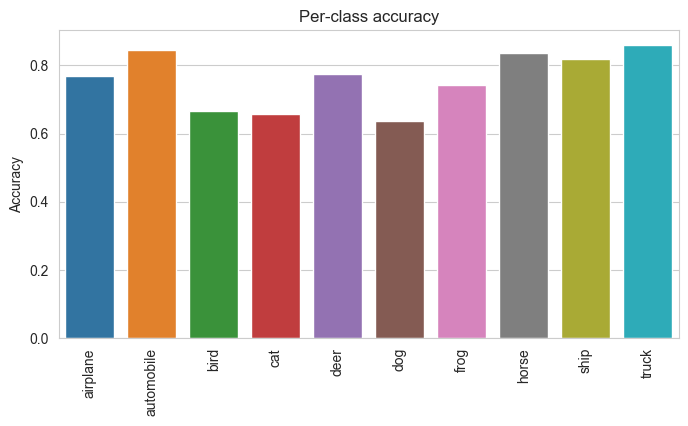

In [284]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**

### Question1)
I reached an accuracy of ~76% on the test set after modifying my code a bit.

### Question2)

I tested several configurations namely: Adam vs. SGD and different learning rates.
* Here I noticed that SGD had slightly better generalizability using the parameters I experimented with (but slightly slower convergence also.)

I also tested different model configurations where I both varied the number of channels in and out as well as the kernel size (5/3). I did not record my results extensively, since it takes a while to train... 
What lead to the highest increase in accuracy for me was adding dropout to the fully connected layers and increasing the number of conv layers along with the channels.

### Question3) 
I have already worked a lot with CNN's so for me there was not any new material.

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [ ]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])


# I already trained on GPU the first time around:)

You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**





### Exercise description:

An extreme version of gradient descent is to use a mini-batch size of just 1. That is, given a training input, x, we update our weights and biases according to the rules 

$$
w_k \to w'_k  = w_k - \eta \frac{\partial C_x}{\partial w_k} 
$$

and 

$$
b_l \to b_l' = b_l -\eta \frac{\partial C_x}{\partial b_l} 
$$ 

Then we choose another training input, and update the weights and biases again. And so on, repeatedly. This procedure is known as online, on-line, or incremental learning. In online learning, a neural network learns from just one training input at a time (just as human beings do). Name one advantage and one disadvantage of online learning, compared to stochastic gradient descent with a mini-batch size of, say, 20. 

#### Advantage:
Doing online learning allows a model to adapt to changes in the data faster and can be used to update a model in close to real-time. Say that you have a noise cancellation model: If you are in the city centre then it has to adapt frequently to the noise to be able to filter it out properly. 
#### Disadvantage:
The model will have a harder time converging and generalizing since each update will be based on a single sample. Maintaining a model trained online in real-time would require that you continually ensure that the model as well as the streamed data is of high quality.
##### Rant...
Ultimately it depends on the application; If the application warrants for quick updates in the model but failures are not critical one should opt for online learning. On the other hand, if the data can largely be assumed to be static, such as background noise in an aeroplane, then one would not need online learning necessarily.